In [1]:
import numpy as np
from math import *
import argparse
import matplotlib.pyplot as plt
import copy
import argparse


class Layer:
    def __init__(self,d,res_xy,res_z,position, ms=0):             
        self.d=d               #width in X0            
        self.res_xy=res_xy           #detector resolution     
        self.res_z=res_z
        self.ms=ms             #multiple scattering deviation
        self.position=position #position of the layer

def beta(p,m):
    '''beta function'''
    return p/sqrt(p*p+m*m)

def msresolution(l,p,m):
    '''calculate the multiscattering resolution'''
    if l.d==0:
        l.ms=0
    else:
        l.ms=0.0136/beta(p,m)/p*sqrt(l.d)*(1+0.038*log(l.d))

def eta2sintheta(eta):
    return (1/cosh(eta))

class Detector:   
    def __init__(self):
        self.layers=[]           #layers    position->Layer   
        self.layerpositions=[]        #layerpositions
        self.N=0                      #number of layers
        
    def addlayer(self, d,res_xy,res_z,position):
        '''Add a layer of detector'''
        if position in self.layerpositions:
            raise ValueError("Cannot add two layer at the same position")
        l=Layer(d,res_xy,res_z,position)
        self.layerpositions.append(position)
        self.layerpositions.sort()
        self.layers.insert(self.layerpositions.index(position),l)
        self.N+=1

    def addlayer2(self, l):
        position=l.position
        if position in self.layerpositions:
            raise ValueError("Cannot add two layer at the same position")
        self.layerpositions.append(position)
        self.layerpositions.sort()
        self.layers.insert(self.layerpositions.index(position),l)
        self.N+=1

    def track(self):
        a1=[1 for i in range(self.N)]
        a2=[self.layerpositions[i] for i in range(self.N)]
        a3=[self.layerpositions[i]*self.layerpositions[i]/2 for i in range(self.N)]
        return np.array((a1,a2,a3))

    def track_linear(self):
        a1=[1 for i in range(self.N)]
        a2=[self.layerpositions[i] for i in range(self.N)]
        return np.array((a1,a2))

    def covariancey_xy(self):
        t1=[]
        for i in range(self.N):
                t2=[]
                for j in range(self.N):
                        Cyij=0.0
                        if i==j:
                                Cyij+=self.layers[i].res_xy*self.layers[i].res_xy
                        for k in range(min([i,j])):
                                Cyij+=self.layers[k].ms*self.layers[k].ms*(self.layerpositions[i]-self.layerpositions[k])*(self.layerpositions[j]-self.layerpositions[k])
                        t2.append(Cyij)
                t1.append(t2)
        return np.array(t1)
    
    def covariancey_z(self):
        t1=[]
        for i in range(self.N):
                t2=[]
                for j in range(self.N):
                        Cyij=0.0
                        if i==j:
                                Cyij+=self.layers[i].res_z*self.layers[i].res_z
                        for k in range(min([i,j])):
                                Cyij+=self.layers[k].ms*self.layers[k].ms*(self.layerpositions[i]-self.layerpositions[k])*(self.layerpositions[j]-self.layerpositions[k])
                        t2.append(Cyij)
                t1.append(t2)
        return np.array(t1)

    def covariancey_z_1(self):
        covy=self.covariancey_z()
        return np.linalg.inv(covy)

    def covariancey_xy_1(self):
        covy=self.covariancey_xy()
        return np.linalg.inv(covy)
    
    def error_z(self):
        def covariancea():
            t=np.dot(self.track(),self.covariancey_z_1())
            t=np.dot(t,self.track().transpose())
            t=np.linalg.inv(t)
            return t       
        return covariancea()

    def error_xy(self):
        t=np.dot(self.track(),self.covariancey_xy_1())
        t=np.dot(t,self.track().transpose())
        t=np.linalg.inv(t)
        return t       
    
    def error_linear_z(self):
        t=np.dot(self.track_linear(),self.covariancey_z_1())
        t=np.dot(t,self.track_linear().transpose())
        t=np.linalg.inv(t)
        return t    

    def error_linear_xy(self):
        t=np.dot(self.track_linear(),self.covariancey_xy_1())
        t=np.dot(t,self.track_linear().transpose())
        t=np.linalg.inv(t)
        return t    
    
    def errorcalculation(self,p,B,eta=0,m=0.106):
        '''return the error
            p for p_T which is the transverse momentum'''
        error=dict()
        sintheta=eta2sintheta(eta)
        tempd=Detector()
        for i in range(self.N):
            l=copy.deepcopy(self.layers[i])
            l.d=l.d/sintheta
            l.position=l.position/sintheta
            msresolution(l,p/sintheta,m)
            tempd.addlayer2(l)
        ca=tempd.error_xy()
        ca_linear=tempd.error_linear_xy()
        error['sigma(pt)/pt']=sqrt(ca[2][2])*p/0.3/B*(1/sintheta)*(1/sintheta)
        #error['sigma(pt)/pt']=sqrt(ca[2][2])*p/(0.3*B)
        error['sigma(d)']=sqrt(ca[0][0])*1e6
        error['sigma(phi)']=sqrt(ca[1][1])/sintheta
        for i in range(self.N):
            tempd.layers[i].res_z=tempd.layers[i].res_z*sintheta
        ca=tempd.error_z()
        ca_linear=tempd.error_linear_z()
        error['sigma(z)']=sqrt(ca_linear[0][0])*1e6/sintheta
        error['sigma(theta)']=sqrt(ca_linear[1][1])
        return error

#examples of detectors
def ATLAS():
    Pixel1=Layer(0.0067,5.0e-5/sqrt(12),5.0e-5/sqrt(12),0.039)
    Pixel2=Layer(0.0067,5.0e-5/sqrt(12),5.0e-5/sqrt(12),0.099)
    Pixel3=Layer(0.0067,5.0e-5/sqrt(12),5.0e-5/sqrt(12),0.16)
    Pixel4=Layer(0.0067,5.0e-5/sqrt(12),5.0e-5/sqrt(12),0.22)
    Pixel5=Layer(0.0067,5.0e-5/sqrt(12),5.0e-5/sqrt(12),0.279)
    Strip1=Layer(0.02,7.575e-5/sqrt(12),7.575e-5/sqrt(12),0.405)
    Strip2=Layer(0.02,7.575e-5/sqrt(12),7.575e-5/sqrt(12),0.562)
    Strip3=Layer(0.02,7.575e-5/sqrt(12),7.575e-5/sqrt(12),0.762)
    Strip4=Layer(0.02,7.575e-5/sqrt(12),7.575e-5/sqrt(12),1)
    detector=Detector()
    detector.addlayer2(Pixel1)
    detector.addlayer2(Pixel2)
    detector.addlayer2(Pixel3)
    detector.addlayer2(Pixel4)
    detector.addlayer2(Pixel5)
    detector.addlayer2(Strip1)
    detector.addlayer2(Strip2)
    detector.addlayer2(Strip3)
    detector.addlayer2(Strip4)
    return detector

def Validation1():
    Pixel1=Layer(0,1e-6,1e-6,0.1)
    Pixel2=Layer(0,1e-6,1e-6,0.2)
    Pixel3=Layer(0,1e-6,1e-6,0.3)
    Pixel4=Layer(0,1e-6,1e-6,0.4)
    Pixel5=Layer(0,1e-6,1e-6,0.5)
    detector=Detector()
    detector.addlayer2(Pixel1)
    detector.addlayer2(Pixel2)
    detector.addlayer2(Pixel3)
    detector.addlayer2(Pixel4)
    detector.addlayer2(Pixel5)
    return detector

def Validation2():
    Pixel1=Layer(0.1,1e-8,1e-8,0.1)
    Pixel2=Layer(0.1,1e-8,1e-8,0.2)
    Pixel3=Layer(0.1,1e-8,1e-8,0.3)
    Pixel4=Layer(0.1,1e-8,1e-8,0.4)
    Pixel5=Layer(0.1,1e-8,1e-8,0.5)
    detector=Detector()
    detector.addlayer2(Pixel5)
    detector.addlayer2(Pixel4)
    detector.addlayer2(Pixel3)
    detector.addlayer2(Pixel2)
    detector.addlayer2(Pixel1)
    return detector

def inputfromfile(filename,verbose):
    if filename==None:return None
    userdetector=Detector()
    if verbose!=None:
        try:
            float(verbose)
            if float(verbose)>1:
                print("Error: verbose number must be either 1 or 0" %verbose)
                return None
        except:
            print("Error: Cannot resolve -verbose %s. It must be a number!" %verbose)
            return None
    try:
        f=open(filename, 'r')
        f.close()
    except:
        print("Error: Cannot open file from %s" %filename)
        return None
    with open(filename, 'r') as f: 
        if verbose:
            print("#\tWidth\tResolutionxy\tResolutionz\tposition")
        lines=f.readlines()
        count=0
        lines=[line for line in lines if len(line.split())==4 and line.split()[0][0]!='#']
        for line in lines:
            try:
                tempt=[float(num) for num in line.split()]
            except:
                print("Error: The input file is not supported, please check that the file is in required format.")
                return None
            count+=1
            d,resolutionxy,resolutionz,position=[float(num) for num in line.split()]
            userdetector.addlayer(d,resolutionxy,resolutionz,position)
            if verbose:
                print('%-3d\t%.5g\t%.5g\t\t%.5g\t\t%.5g'%(count,d,resolutionxy,resolutionz,position))
    if count==0:
        print("Error: The input file is not supported or empty, please check that the file is in required format.")
        return None
    print("Successfully read %d layers" %count)
    return userdetector

def addparser():
    parser = argparse.ArgumentParser(description='Detector resolution calculation.\nWritten by Feng Chen')
    parser.add_argument('-f', '--foo',help='input file at F00',default="CLD.txt")
    parser.add_argument('-m', '--m',help='mass of the particle in GeV/c^2 (default: muon mass)',default=0.106)
    parser.add_argument('-B', '--B',help='magnetic field in T (default: 2T)',default=2)
    parser.add_argument('-eta', '--eta',help='pseudorapidity (default: 0)',default=0)
    parser.add_argument('-p', '--p',help='momentum of the particle in GeV/c (default: 1 GeV)',default=1)
    parser.add_argument('-verbose', '--verbose',help='set to 1 to print the input layer configuration (default: 0)',default=0)
    args = parser.parse_args() 
    return [inputfromfile(args.foo,args.verbose), args.p,args.B,args.eta,args.m]

def calculation():
    detector,p,B,eta,m=addparser()
    if detector!=None:
        try:
            p=float(p)
        except:
            print("Error: Cannot resolve -p %s. It must be a number!" %p)
            return
        try:
            B=float(B)
        except:
            print("Error: Cannot resolve -B %s. It must be a number!" %B)
            return
        try:
            m=float(m)
        except:
            print("Error: Cannot resolve -m %s. It must be a number!" %m)
            return
        try:
            eta=float(eta)
        except:
            print("Error: Cannot resolve -eta %s. It must be a number!" %eta)
            return
        error=detector.errorcalculation(p,B,eta,m)
        for quantity in error.keys():
            print(quantity+'=%.4g'%error[quantity])
        return 1
    else:
        print('No detector is selected.')

def main():
    #print(Validation2().errorcalculation(1,2))
    print("load successfully")
    calculation()

if __name__ =="__main__":
    main()

    
 
# Plot is a function of the file input, the error variable (i.e. 'sigma(d)'), and the B field (default = 2T).

def plot(filename,var,B=2,eta=0,m=0.106):
    mydetector = inputfromfile(filename,1)
    p = np.logspace(-0.1,2.1)
    y = []
    for i in range(len(p)):
        y.append(mydetector.errorcalculation(p[i],B,eta,m)[var])
    print(y[0])
    plt.xscale('log')
    plt.plot(p,y,label="Calculation")
    plt.legend
    return mydetector

load successfully
Error: The input file is not supported or empty, please check that the file is in required format.
No detector is selected.


#	Width	Resolutionxy	Resolutionz	position
1  	0.00227	9999		9999		0.024
2  	0.01225	1.5e-05		1.5e-05		0.032
3  	0.01225	1.5e-05		1.5e-05		0.068
4  	0.01225	1.5e-05		1.5e-05		0.113
5  	0.01225	1.5e-05		1.5e-05		0.17
6  	0.01475	4.3e-05		0.0012		0.26
7  	0.01475	4.3e-05		0.0012		0.36
8  	0.01475	4.3e-05		0.0012		0.5
9  	0.01475	4.3e-05		0.0012		0.6
Successfully read 9 layers
61.43468904231135


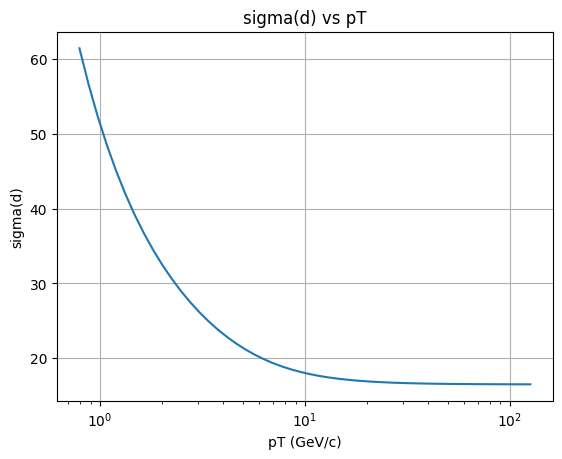

#	Width	Resolutionxy	Resolutionz	position
1  	0.00227	9999		9999		0.024
2  	0.01225	1.5e-05		1.5e-05		0.032
3  	0.01225	1.5e-05		1.5e-05		0.068
4  	0.01225	1.5e-05		1.5e-05		0.113
5  	0.01225	1.5e-05		1.5e-05		0.17
6  	0.01475	4.3e-05		0.0012		0.26
7  	0.01475	4.3e-05		0.0012		0.36
8  	0.01475	4.3e-05		0.0012		0.5
9  	0.01475	4.3e-05		0.0012		0.6
Successfully read 9 layers
60.53760903526987


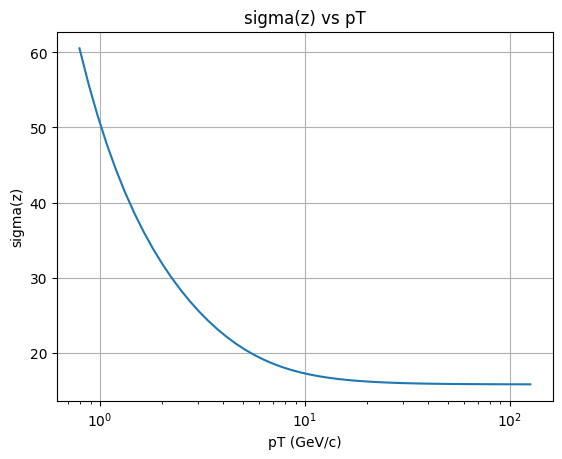

#	Width	Resolutionxy	Resolutionz	position
1  	0.00227	9999		9999		0.024
2  	0.01225	1.5e-05		1.5e-05		0.032
3  	0.01225	1.5e-05		1.5e-05		0.068
4  	0.01225	1.5e-05		1.5e-05		0.113
5  	0.01225	1.5e-05		1.5e-05		0.17
6  	0.01475	4.3e-05		0.0012		0.26
7  	0.01475	4.3e-05		0.0012		0.36
8  	0.01475	4.3e-05		0.0012		0.5
9  	0.01475	4.3e-05		0.0012		0.6
Successfully read 9 layers
0.0018433971278649004


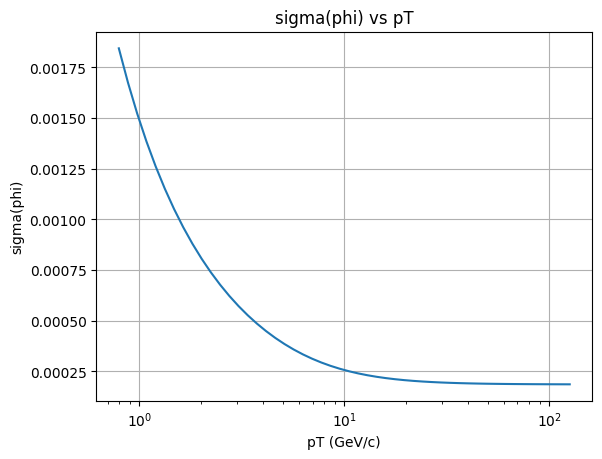

#	Width	Resolutionxy	Resolutionz	position
1  	0.00227	9999		9999		0.024
2  	0.01225	1.5e-05		1.5e-05		0.032
3  	0.01225	1.5e-05		1.5e-05		0.068
4  	0.01225	1.5e-05		1.5e-05		0.113
5  	0.01225	1.5e-05		1.5e-05		0.17
6  	0.01475	4.3e-05		0.0012		0.26
7  	0.01475	4.3e-05		0.0012		0.36
8  	0.01475	4.3e-05		0.0012		0.5
9  	0.01475	4.3e-05		0.0012		0.6
Successfully read 9 layers
0.0017916519741984266


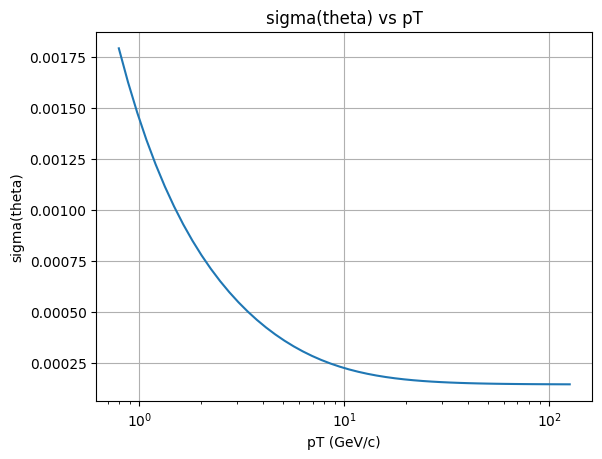

#	Width	Resolutionxy	Resolutionz	position
1  	0.00227	9999		9999		0.024
2  	0.01225	1.5e-05		1.5e-05		0.032
3  	0.01225	1.5e-05		1.5e-05		0.068
4  	0.01225	1.5e-05		1.5e-05		0.113
5  	0.01225	1.5e-05		1.5e-05		0.17
6  	0.01475	4.3e-05		0.0012		0.26
7  	0.01475	4.3e-05		0.0012		0.36
8  	0.01475	4.3e-05		0.0012		0.5
9  	0.01475	4.3e-05		0.0012		0.6
Successfully read 9 layers
0.010650391764756503


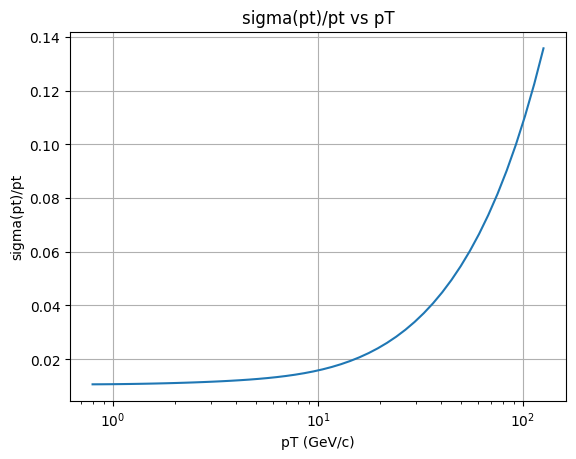

In [6]:
for var in ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']:
    plot("ODD.txt", var, B=2, eta=0.0, m=0.106)
    plt.title(var + ' vs pT')
    plt.xlabel('pT (GeV/c)')
    plt.ylabel(var)
    plt.grid()
    plt.show()
